# Predicting Sports Winners with Decision Trees

NBA(National Basketball Association) 경기의 승패는 마지막 순간에 결정되어 승자 예측이 어려운 경우가 많다.

2013-2014 년도 NBA 데이터셋과 decision trees 모델을 사용하여 게임의 승자를 예측해보자.

NBA dataset 
```
https://www.basketball-reference.com/leagues/NBA_2014_games-november.html
```

## Using pandas to load the dataset

In [1]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from collections import defaultdict

In [6]:
np.random.seed(1004)

In [7]:
dataset = pd.read_csv('./dataset/NBA_14oct-jun.csv')

In [8]:
dataset.rename(columns={'PTS': 'visitorPTS', 'PTS.1': 'homePTS', 'Unnamed: 6':'Score type', 'Unnamed: 7':'OT?','Attend.':'Attend', 'Visitor/Neutral':'Visitor team', 'Home/Neutral':'Home team'}, inplace=True)

In [9]:
# 일부 Column만 사용
dataset = dataset[['Visitor team','visitorPTS','Home team','homePTS']]
dataset.head(3)

,Visitor team,visitorPTS,Home team,homePTS
0,Orlando Magic,84,New Orleans Pelicans,101
1,Dallas Mavericks,100,San Antonio Spurs,101
2,Houston Rockets,108,Los Angeles Lakers,90


## Extracting new features

데이터로부터 다음과 같은 feature들을 추출.
* HomeLastWin : 홈팀이 지난경기에서 이기면 1, 지면 0  
* VisitorLastWin : 원정팀이 지난경기에서 이기면 1, 지면 0  
* HomeTeamRanksHigher : 홈팀 랭킹이 원정팀 랭킹보다 높으면 1, 아니면 0  
* HomeTeamWonLast : 지난 홈팀 vs 원정팀 경기에서 홈팀이 이겼으면 1, 아니면 0

In [10]:
dataset["HomeWin"] = dataset["visitorPTS"] < dataset["homePTS"]

In [11]:
y_true = dataset["HomeWin"].values
print(y_true.shape)

(1311,)


In [12]:
y_true[:10]

array([ True,  True, False,  True,  True,  True,  True,  True, False,
        True])

In [13]:
won_last = defaultdict(int)

In [14]:
dataset2 = pd.DataFrame()
for index, row in dataset.iterrows():  
    home_team = row["Home team"]  
    visitor_team = row["Visitor team"] 
    row["HomeLastWin"] = won_last[home_team] 
    row["VisitorLastWin"] = won_last[visitor_team]
    won_last[home_team] = row["HomeWin"]
    won_last[visitor_team] = not row["HomeWin"]
    dataset.iloc[index] = row
    dataset2 = dataset2.append(row)

In [17]:
dataset2.shape

(1311, 7)

In [15]:
dataset2.tail(3)

,Home team,HomeLastWin,HomeWin,Visitor team,VisitorLastWin,homePTS,visitorPTS
1308,Cleveland Cavaliers,1.0,0.0,Golden State Warriors,0.0,82.0,103.0
1309,Golden State Warriors,1.0,1.0,Cleveland Cavaliers,0.0,104.0,91.0
1310,Cleveland Cavaliers,0.0,0.0,Golden State Warriors,1.0,97.0,105.0


We will create a feature that tells us if the home team is generally better than the visitors. To do this, we will load the standings (also called a ladder in some sports) from the NBA in the previous season. A team will be considered better if it ranked higher in 2013 than the other team.

In [18]:
data_folder = './'

In [21]:
standings_filename = os.path.join(data_folder, "./dataset/NBA_14standings.csv")
standings = pd.read_csv(standings_filename)

In [22]:
standings.head(2)

,Rk,Team,Overall,Home,Road,E,W,A,C,SE,...,Post,≤3,≥10,Oct,Nov,Dec,Jan,Feb,Mar,Apr
0,1,Golden State Warriors,67-15,39-2,28-13,25-5,42-10,9-1,7-3,9-1,...,25-6,5-3,45-9,1-0,13-2,11-3,12-3,8-3,16-2,6-2
1,2,Atlanta Hawks,60-22,35-6,25-16,38-14,22-8,12-6,14-4,12-4,...,17-11,6-4,30-10,0-1,9-5,14-2,17-0,7-4,9-7,4-3


As an important adjustment to the data, a team was renamed between the 2014 and 2015 seasons (but it was still the same team). We will need to adjust.

* HomeTeamRanksHigher : 홈팀 랭킹이 원정팀 랭킹보다 높으면 1, 아니면 0

In [23]:
dataset2["HomeTeamRanksHigher"] = 0

dataset3 = pd.DataFrame()
for index, row in dataset2.iterrows():
    home_team = row["Home team"]
    visitor_team = row["Visitor team"]
    home_rank = standings[standings["Team"] == home_team]["Rk"].values[0]
    visitor_rank = standings[standings["Team"] == visitor_team]["Rk"].values[0]
    row["HomeTeamRanksHigher"] = int(home_rank > visitor_rank)
    dataset2.iloc[index] = row
    dataset3 = dataset3.append(row)

In [24]:
dataset3.head(2)

,Home team,HomeLastWin,HomeTeamRanksHigher,HomeWin,Visitor team,VisitorLastWin,homePTS,visitorPTS
0,New Orleans Pelicans,0.0,0.0,1.0,Orlando Magic,0.0,101.0,84.0
1,San Antonio Spurs,0.0,0.0,1.0,Dallas Mavericks,0.0,101.0,100.0


In [25]:
last_match_winner = defaultdict(int)
dataset3["HomeTeamWonLast"] = 0

In [26]:
dataset4 = pd.DataFrame()
for index, row in dataset3.iterrows():
    home_team = row["Home team"]
    visitor_team = row["Visitor team"]
    teams = tuple(sorted([home_team, visitor_team]))
    row["HomeTeamWonLast"] = 1 if last_match_winner[teams] == row["Home team"] else 0
    winner = row["Home team"] if row["HomeWin"] else row ["Visitor team"]
    last_match_winner[teams] = winner
    dataset4 = dataset4.append(row)

HomeTeamWonLast : 지난 홈팀 vs 원정팀 경기에서 홈팀이 이겼으면 1, 아니면 0

In [27]:
dataset4 = dataset4[['Visitor team', 'visitorPTS', 'Home team', 'homePTS','HomeWin','HomeLastWin','VisitorLastWin', 'HomeTeamRanksHigher','HomeTeamWonLast']]

In [28]:
dataset4.head(2)

,Visitor team,visitorPTS,Home team,homePTS,HomeWin,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher,HomeTeamWonLast
0,Orlando Magic,84.0,New Orleans Pelicans,101.0,1.0,0.0,0.0,0.0,0.0
1,Dallas Mavericks,100.0,San Antonio Spurs,101.0,1.0,0.0,0.0,0.0,0.0


In [29]:
dataset4.to_csv('./NBA_14_all.csv',index = False)

We will also try putting the raw teams into the algorithm to check whether the algorithm can learn a model that checks how different teams play against each other

In [30]:
from sklearn.preprocessing import LabelEncoder
encoding = LabelEncoder()

In [31]:
encoding.fit(dataset4["Home team"].values)

LabelEncoder()

In [32]:
home_teams = encoding.transform(dataset4["Home team"].values)
visitor_teams = encoding.transform(dataset4["Visitor team"].values)
X_teams = np.vstack([home_teams, visitor_teams]).T

In [33]:
print(home_teams[:5])  
print(X_teams.shape)

[18 26 13  3 11]
(1311, 2)


In [34]:
X_teams[0]

array([18, 21])

In [35]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()

In [36]:
X_teams_expanded = onehot.fit_transform(X_teams).todense()

/home/seung/.venv/tf200py368/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [37]:
X_teams_expanded[0]  

matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [38]:
X_teams_expanded[0].shape

(1, 60)

In [39]:
X_teams_expanded.shape

(1311, 60)

In [40]:
dataset4 = pd.concat([dataset4, pd.DataFrame(X_teams_expanded)], axis=1)

In [41]:
dataset4.shape

(1311, 69)

In [42]:
dataset5 = dataset4.iloc[:,5:]

#### Feature explaination
* HomeLastWin : Did the home team win the last game?
* VisitorLastWin : Did the visitor team win the last game?
* HomeTeamRanksHigher : Does the home team rank higher than the visitor team?
* HomeTeamWonLast : Did the home team win last home vs visitor game?
* 0-60 : one-hot encoding team number --> hometeam(0-29), visitor team(30-59)

In [44]:
dataset5.shape

(1311, 64)

In [47]:
print('Dimension of features =' , dataset5.shape[1])

Dimension of features = 64


In [48]:
dataset5.tail(3)

,HomeLastWin,VisitorLastWin,HomeTeamRanksHigher,HomeTeamWonLast,0,1,2,3,4,5,...,50,51,52,53,54,55,56,57,58,59
1308,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1309,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1310,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Data spilit

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset5, y_true, test_size=0.3, random_state=0)

In [50]:
X_train.shape, X_test.shape

((917, 64), (394, 64))

### Neual Network

In [51]:
from tensorflow.keras import models, layers

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [90]:
model = models.Sequential()

In [91]:
# adding the layers
model.add(layers.Dense(64*2, activation='relu', input_shape=[X_train.shape[1]]))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
# output layer
model.add(layers.Dense(1, activation='sigmoid'))

In [92]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 18,689
Trainable params: 18,689
Non-trainable params: 0
_________________________________________________________________


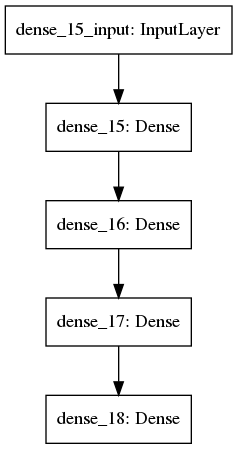

In [99]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [93]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [94]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100)

Epoch 1/100
23/23 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5438 - val_loss: 0.6602 - val_accuracy: 0.6413
Epoch 2/100
23/23 [==============================] - 0s 2ms/step - loss: 0.6255 - accuracy: 0.7180 - val_loss: 0.6400 - val_accuracy: 0.6467
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5797 - accuracy: 0.7120 - val_loss: 0.6470 - val_accuracy: 0.6467
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 0.5495 - accuracy: 0.7126 - val_loss: 0.6585 - val_accuracy: 0.6413
Epoch 5/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4939 - accuracy: 0.7487 - val_loss: 0.6875 - val_accuracy: 0.6467
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4718 - accuracy: 0.7611 - val_loss: 0.6883 - val_accuracy: 0.6467
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 0.4506 - accuracy: 0.7700 - val_loss: 0.7163 - val_accuracy: 0.6250
Epoch 8/100
2

Epoch 59/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0288 - accuracy: 0.9825 - val_loss: 2.2593 - val_accuracy: 0.5326
Epoch 60/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0324 - accuracy: 0.9893 - val_loss: 2.0403 - val_accuracy: 0.6250
Epoch 61/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0198 - accuracy: 0.9870 - val_loss: 2.1447 - val_accuracy: 0.5435
Epoch 62/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0283 - accuracy: 0.9855 - val_loss: 2.0469 - val_accuracy: 0.5978
Epoch 63/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 0.9901 - val_loss: 2.2348 - val_accuracy: 0.5435
Epoch 64/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0200 - accuracy: 0.9910 - val_loss: 2.0789 - val_accuracy: 0.6141
Epoch 65/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0281 - accuracy: 0.9853 - val_loss: 2.1345 - val_accuracy: 0.5652
Epoch 

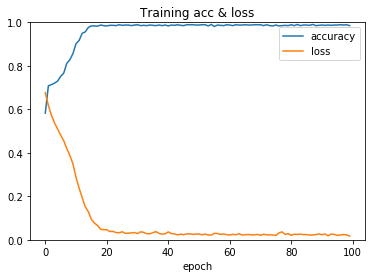

In [95]:
import matplotlib.pyplot as plt

training_error = history.history['accuracy'] # training error
val_error = history.history['loss'] # validation error

plt.plot(training_error)
plt.plot(val_error)
plt.title('Training acc & loss')
plt.legend(['accuracy', 'loss'], loc='upper right')
plt.ylim(0, 1)
plt.xlabel('epoch')

plt.show()

In [96]:
score = model.evaluate(X_train, y_train)
print('train_acc: {}'.format(score[1]))

29/29 [==============================] - 0s 782us/step - loss: 0.4737 - accuracy: 0.9062
train_acc: 0.9062159061431885


In [97]:
score = model.evaluate(X_test, y_test)
print('test_acc: {}'.format(score[1]))

13/13 [==============================] - 0s 1ms/step - loss: 2.1492 - accuracy: 0.6421
test_acc: 0.6421319842338562


### Conventional approach

https://towardsdatascience.com/building-my-first-machine-learning-model-nba-prediction-algorithm-dee5c5bc4cc1

In [117]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)
clf.fit(X_train, y_train)
print('Train Acc = ', clf.score(X_train,y_train))
print('Test Acc = ', clf.score(X_test,y_test))

Train Acc =  0.707742639040349
Test Acc =  0.7030456852791879


In [118]:
feature_names = dataset5.columns

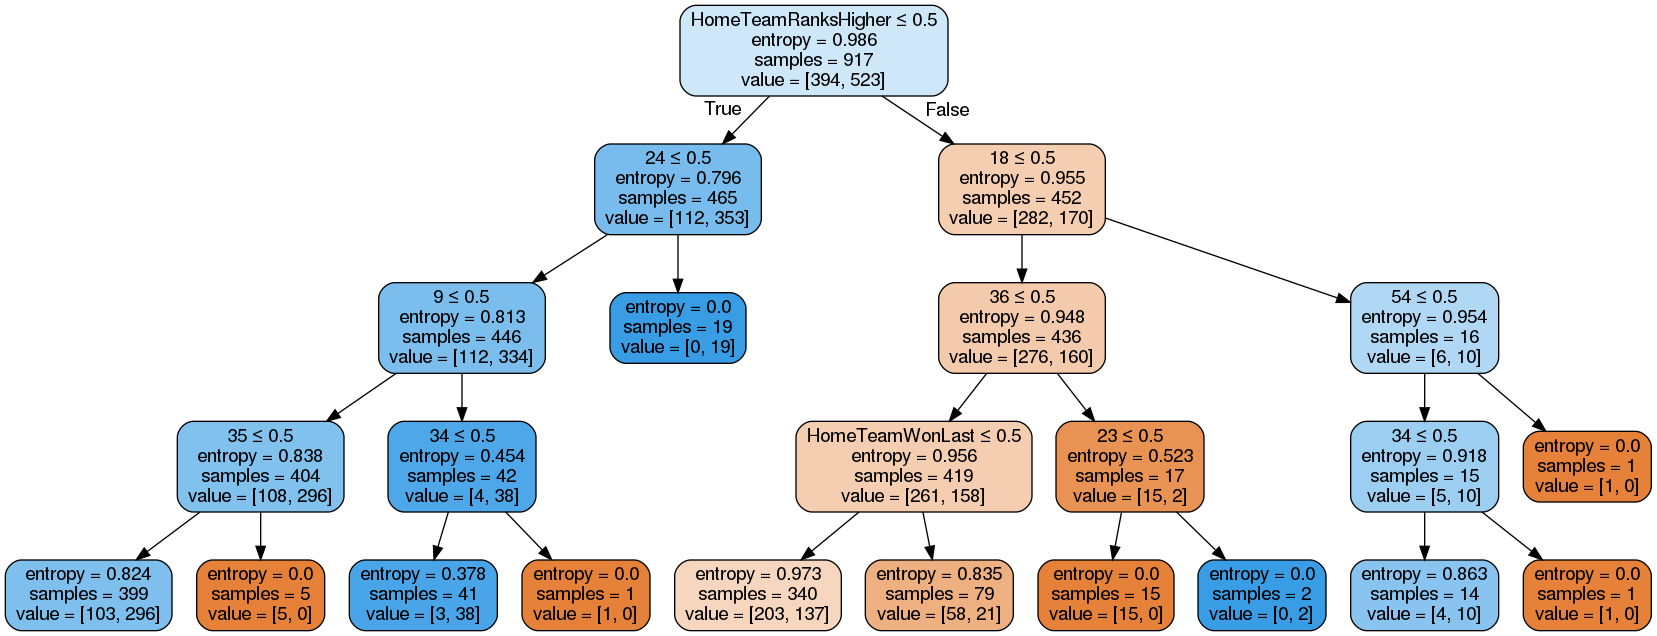

In [119]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

dot_data = export_graphviz(clf, out_file=None, feature_names=feature_names,
                           filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [105]:
# LinearSVC classification 
from sklearn.svm import LinearSVC
lclf = LinearSVC(random_state=0, tol=1e-5, max_iter=1000)
lclf.fit(X_train, y_train)
print('Train Acc = ', lclf.score(X_train,y_train))
print('Test Acc = ', lclf.score(X_test,y_test))

Train Acc =  0.707742639040349
Test Acc =  0.6979695431472082


In [106]:
# KNN model attempt 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
print('Train Acc = ', knn.score(X_train,y_train))
print('Test Acc = ', knn.score(X_test,y_test))

Train Acc =  0.7121046892039259
Test Acc =  0.6675126903553299


In [107]:
# SVC prediction model attempt 
from sklearn.svm import SVC
from sklearn import svm
clf = SVC(gamma='scale',probability=True)
clf.fit(X_train, y_train)
print('Train Acc = ', clf.score(X_train,y_train))
print('Test Acc = ', clf.score(X_test,y_test))

Train Acc =  0.7284623773173392
Test Acc =  0.7055837563451777


In [108]:
#BaggingSVC Ensemble classification 
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
advclf = BaggingClassifier(base_estimator=SVC(gamma='scale'), n_estimators=10, random_state=0)
advclf.fit(X_train, y_train)
print('Train Acc = ', advclf.score(X_train,y_train))
print('Test Acc = ', advclf.score(X_test,y_test))

Train Acc =  0.7753544165757906
Test Acc =  0.7030456852791879


In [114]:
# Random Forest Classification model
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=8, random_state=0, n_estimators=300)
rdf.fit(X_train, y_train)
print('Train Acc = ', rdf.score(X_train,y_train))
print('Test Acc = ', rdf.score(X_test,y_test))

Train Acc =  0.7546346782988005
Test Acc =  0.7182741116751269


### References  
https://hub.packtpub.com/predicting-sports-winners-decision-trees-and-pandas/, Ch.3